# Full pipeline one step at a time

In [208]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
from DLC_for_WBFM.utils.point_clouds.utils_bcpd import match_2vol_BCPD, match_2vol_rigid


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

# Actually import
import_opt = {'num_slices':33, 'alpha':0.15}

dat0_vid = get_single_volume(btf_fname_red, 0, **import_opt)
dat1_vid = get_single_volume(btf_fname_red, 1, **import_opt)

## First, single-volume segmentation

In [3]:
opt = {'num_slices':33, 'alpha':1.0}
# Build point clouds for each plane
all_keypoints_pcs0 = build_point_clouds_for_volume(dat0_vid, **import_opt)
all_icp0 = build_correspondence_icp(all_keypoints_pcs0)

all_keypoints_pcs1 = build_point_clouds_for_volume(dat0_vid, **import_opt)
all_icp1 = build_correspondence_icp(all_keypoints_pcs1)

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


In [4]:
all_neurons = [k.points for k in all_keypoints_pcs0]
all_matches = [m.correspondence_set for m in all_icp0]
clust_df0 = build_tracklets_from_matches(all_neurons, all_matches)

all_neurons = [k.points for k in all_keypoints_pcs1]
all_matches = [m.correspondence_set for m in all_icp1]
clust_df1 = build_tracklets_from_matches(all_neurons, all_matches)

In [5]:
# Visualize
# Build full point cloud

full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs0:
    full_pc = full_pc + pc
full_pc.paint_uniform_color([0.5,0.5,0.5])

#out = visualize_clusters_from_dataframe(full_pc, clust_df0)

PointCloud with 326 points.

## Next, matching two volumes

In [6]:
opt = {'num_slices':33, 'alpha':1.0, 'verbose':1}
neurons0, df0, icp0, pcs0 = detect_neurons_using_ICP(dat0_vid, **opt)
neurons1, df1, icp1, pcs1 = detect_neurons_using_ICP(dat1_vid, **opt)

Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons
Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons


In [31]:
from probreg import bcpd
from tqdm import tqdm
import itertools
#bcpd.registration_bcpd()

In [152]:
def test_bcp_params(pts0, pts1, params, opt={}):

    all_matches = []
    for l, k, g in tqdm(params, total=len(params)):
        bcpd_kwargs = {'lmd':l, 'k':k, 'gamma':g}
        try:
            m, all_conf = match_2vol_BCPD(C,pts1,
                                          do_zscore=True,
                                            bcpd_kwargs=bcpd_kwargs,
                                            **opt)
        except:
            counts = [0]
            m = []
        all_matches.append(m)
        
    all_counts = []
    all_overmatch = []
    for m in all_matches:
        if len(m)>0:
            vals, counts = np.unique(np.array(m)[:,1], return_counts=True)
        else:
            counts = [0]
        all_counts.append(counts)
        all_overmatch.append(max(counts))
    
    return all_counts, all_matches, all_overmatch

In [149]:
lmd_vec = [0.5, 10.0]
k_vec = [1e20]
gamma_vec = [0.1, 1.0]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

all_counts, all_matches, all_overmatch = \
    test_bcp_params(neurons0, neurons1, params)

100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


Text(0, 0.5, '0')

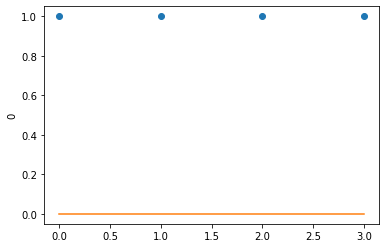

In [150]:
this_var = 0
x = [p[this_var] for p in params]
y = [len(c) for c in all_counts]
use_x = False
if use_x:
    plt.plot(x, y, 'o')
    plt.plot(x, all_overmatch, '.')
else:
    plt.plot(y, 'o')
    plt.plot(all_overmatch)
plt.ylabel(this_var)

In [148]:
which_p = 2
m = all_matches[which_p]
print("Number of matches found: ", len(m))
print(params[which_p])
if len(m)>0:
    visualize_tracks(neurons0, neurons1, m, to_plot_failed_lines=False)

Number of matches found:  0
(10.0, 1e+20, 0.1)


# Match keypoints instead of the neurons

In [174]:
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *

ref_frames, all_matches, pairwise_matches, pairwise_conf, feature_matches = track_via_reference_frames(btf_fname_red, num_reference_frames=2)

  0%|                                                                     | 0/2 [00:00<?, ?it/s]

Pairwise matching all reference frames...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

WIP... aborting early


In [187]:
kp0 = ref_frames[0].keypoint_locs#[:200]
kp1 = ref_frames[1].keypoint_locs#[:200]

lmd_vec = [0.1, 1.0, 10.0]
k_vec = [1e10, 1e20]
gamma_vec = [0.1, 1.0, 10.0]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

opt = {'voxel_size':1.0}

all_counts, all_matches, all_overmatch = \
    test_bcp_params(kp0, kp1, params, opt)

100%|███████████████████████████████████████████████████████████████████| 18/18 [00:00<?, ?it/s]


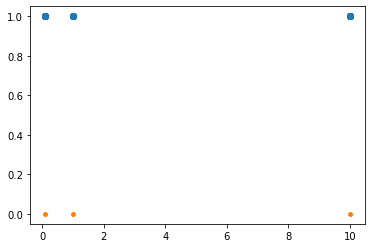

In [188]:

y = [len(c) for c in all_counts]
plt.plot(x, y, 'o')
plt.plot(x, all_overmatch, '.')


In [189]:
m = all_matches[0]
print(m)
if len(m)>0:
    visualize_tracks(kp0, kp1, m, to_plot_failed_lines=False)

[]


# Match Blobs instead of neurons

In [45]:
opt = {'num_slices':33, 'alpha':1.0, 'verbose':1}
neurons0, df0, icp0, pcs0 = detect_neurons_using_ICP(dat0_vid, **opt)
neurons1, df1, icp1, pcs1 = detect_neurons_using_ICP(dat1_vid, **opt)

Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons
Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons


In [153]:
all_pts0 = []
all_pts1 = []
start_plane = 1

for i, (p0, p1) in enumerate(zip(pcs0, pcs1)):
    if i < start_plane:
        continue
    
    all_pts0.extend(np.array(p0.points))
    all_pts1.extend(np.array(p1.points))

all_pts0 = np.array(all_pts0)
all_pts1 = np.array(all_pts1)

In [266]:
lmd_vec = [0.1]
k_vec = [1e10]
gamma_vec = [10.0]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

opt = {'voxel_size':0.3, 'tf_type_name':'rigid'}

all_counts, all_matches, all_overmatch = \
    test_rigid_params(all_pts0, all_pts1, params, opt)

100%|█████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


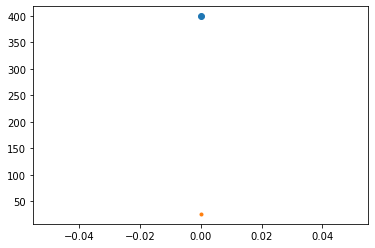

In [267]:

y = [len(c) for c in all_counts]
plt.plot(y, 'o')
plt.plot(all_overmatch, '.')


In [268]:
m = all_matches[0]
visualize_tracks(all_pts0, all_pts1, m, to_plot_failed_lines=False)

# Back to matching neurons, but just rigidly

In [259]:
def test_rigid_params(pts0, pts1, params, opt={}):

    all_matches = []
    for l, k, g in tqdm(params, total=len(params)):
        bcpd_kwargs = {'lmd':l, 'k':k, 'gamma':g}
        #try:
        m, all_conf = match_2vol_rigid(pts0,pts1,
                                            **opt)
        #except:
        #    counts = [0]
        #    m = []
        all_matches.append(m)
        
    all_counts = []
    all_overmatch = []
    for m in all_matches:
        if len(m)>0:
            vals, counts = np.unique(np.array(m)[:,1], return_counts=True)
        else:
            counts = [0]
        all_counts.append(counts)
        all_overmatch.append(max(counts))
    
    return all_counts, all_matches, all_overmatch

In [234]:
lmd_vec = [0.1]
k_vec = [1e10]
gamma_vec = [0.1]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

opt = {'voxel_size':None, 'DEBUG':False}

all_counts, all_matches, all_overmatch = \
    test_rigid_params(neurons0, neurons1, params, opt)

100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.97it/s]


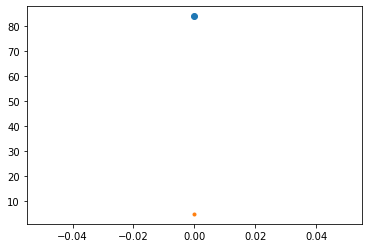

In [235]:

y = [len(c) for c in all_counts]
plt.plot(y, 'o')
plt.plot(all_overmatch, '.')


In [236]:
m = all_matches[0]
visualize_tracks(neurons0, neurons1, m, to_plot_failed_lines=False)